<div style="text-align: right"> 

### DATA 22100 - Introduction to Machine Learning

</div>

<img src="https://github.com/david-biron/DATA221imgs/blob/main/UChicago_DSI.png?raw=true" align="right" alt="UC-DSI" width="300">





<center> 

# Introduction to Linear AutoEncoders
    
<br>
    
</center> 

    

### A comment about installing pytorch

(Different versions of pytorch play nice with different processors; if the latest version does not work - tinker). 

In [1]:
# !pip3 uninstall -y torchvision torch
# !pip3 install torchvision # ==0.14.1
# !pip3 install torch # ==1.13.1 


### A few modules and functions will come in handy:

* [`torch`](https://pytorch.org/docs/stable/torch.html) - data structures for multi-dimensional tensors, mathematical operations over these tensors, and other useful utilities.
* [`DataLoader`](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) - enables easy access to the data samples. <br/> Instead of  retrieving features/labels one sample at a time when training a model, <br/> passing samples in "minibatches", reshuffling the data at every epoch to reduce overfitting, <br/> and using Python's multiprocessing to speed up data retrieval is recommended. <br/> DataLoader is an iterable that abstracts this complexity in an easy API.
* [`transforms`](https://pytorch.org/vision/0.9/transforms.html) - common image transformations that can be chained together using `Compose`. 
* `dataset.MNIST` / `dataset.FashionMNIST` - pre-loaded datasets.  

In [4]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST, FashionMNIST
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib import colormaps
plt.style.use('fivethirtyeight')


print('torch version: ', torch.__version__)
print('cuda available? ', torch.cuda.is_available()) 
# However, in 2022 PyTorch introduced GPU support 
# for Apple's ARM M1 chips. 
# To use it, torch.device('mps') (Metal Performance Shaders )
# is analogous to torch.device('cuda') on an Nvidia GPU. 
# Using torch.device('mps') requires MacOS 12.3 or higher. 


torch version:  2.2.0.post100
cuda available?  False


In [5]:
####################################################################
# Set up using torchvision.transforms for preprocessing each image #   
####################################################################

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


## The MNIST dataset

* The [MNIST subset of **handwritten digits**](http://yann.lecun.com/exdb/mnist/) consits of pairs  of handwritten digit images and labels. 
* It contains a training set of $60,000$ examples and a testing set of $10,000$ examples.
* NIST curated the full dataset.
* The digits have been size-normalized to $28 \times 28$ pixels and centered. 
* It is a widely used to test learning techniques and pattern recognition methods <br/> because of its availability and convenience (little to no preprocessing required).
* However, it is a somewhat 'easy' dataset: <br/> models that test well on MNIST don't necessarily work well on more complex datasets. 

## The Fashion-MNIST dataset

* Similar to MNIST, but with pairs of greyscale images of fashion items and labels (digits): 


|           |                 | 
|:---------:|:---------------:|
| **Label**	| **Description** |
| 0         | T-shirt/top     |
| 1         | Trouser         | 
| 2         | Pullover        | 
| 3         | Dress           | 
| 4         | Coat            | 
| 5         | Sandal          | 
| 6         | Shirt           | 
| 7         | Sneaker         | 
| 8         | Bag             | 
| 9         | Ankle boot      | 


In [6]:
################################################
#        Load data from a local folder         #
#   (some sources have naming discrepancies)   #
################################################

# mndata = MNIST('data/MNIST', transform=img_transform, download=True)
mndata = FashionMNIST('data/Fashion-MNIST', transform=img_transform, 
                      download=True)
img_side = 28
n_mnist_pixels = img_side*img_side


#### Technical note: extracting an image from a dataloader batch

In [7]:
num_samples = 3 
dataloader = DataLoader(mndata, batch_size=num_samples, shuffle=True)
for data,sample in zip(dataloader, range(num_samples)):
    image1, labels = data
    image2 = image1.view(image1.size(0), -1) # reshape to 
                                             # '(batch size) x (784)'
    print(image1.shape, '-->' ,image2.shape)


torch.Size([3, 1, 28, 28]) --> torch.Size([3, 784])
torch.Size([3, 1, 28, 28]) --> torch.Size([3, 784])
torch.Size([3, 1, 28, 28]) --> torch.Size([3, 784])


### What do the data images look like?  

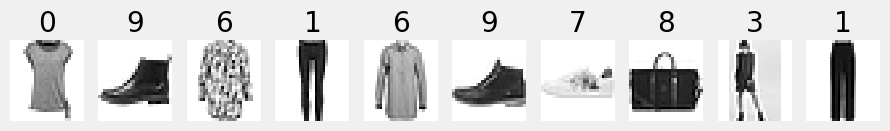

In [8]:
#############################
#  Display a few examples   #
#############################

num_samples = 10
dataloader = DataLoader(mndata, batch_size=num_samples, shuffle=True)

plt.figure(figsize=(10,1))
for data,sample in zip(dataloader, range(num_samples)):
    image, labels = data
    image = image.view(image.size(0), -1) # reshape to 
                                          # '(batch size) x (784)'
    image = image[sample].reshape(28,28) # reshape single image 
                                         # to 28x28

    plt.subplot(1, num_samples, sample+1)    
    plt.title(labels[sample].detach().numpy())
    plt.imshow(image, interpolation='none', aspect='auto', 
               cmap = cm.binary)
    plt.axis('off')


### Overview

* **Design the model** (input, hidden layers, activation functions, output...) 
* **Create instances** of the:
    * Model
    * Loss function 
    * Optimizer
* **Train the model.** <br/> For each epoch: <br/> $ \hspace{8mm}$ For each sample or batch of samples: <br/> $ \hspace{16mm} \circ$ Forward pass (calculate prediction) <br/> $ \hspace{16mm} \circ$ Calculate loss <br/> $ \hspace{16mm} \circ$  Backward pass (calculate gradient) <br/> $ \hspace{16mm} \circ$ Optimizer step (update weights) <br/> $ \hspace{16mm} \circ$ (zero the gradients)
* **Test/evaluate the model** using a testing dataset that was set aside (we may skip this here). 



## A linear AutoEncoder

|   |   |
|:--|:--|
| <img src="https://github.com/david-biron/DATA221imgs/blob/main/icon_definition.png?raw=true" width="50" height=""> | An **autoencoder** is an artificial neural network that learns efficient data codings in an **unsupervised** manner. <br/> The autoencoder learns (weights for) two functions: |
* An **encoder** that transforms the input data to a **dimensionality reduced** representation. 
* A **decoder** that recreates the input data from the encoded representation. 

<img src="https://github.com/david-biron/DATA221imgs/blob/main/AutoEncoderDiagram.png?raw=true" width="500">

* A linear autoencoder uses linear (fully connected) layers in the encoder and the decoder.  


<br> 



### Implementing a linear autoencoder using pytorch

* [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) is a base class for all neural network modules. <br/> The AE should be a subclass of this class (this abstracts a lot of setup).
* The encoder below will reduce the dimensionality of an image from $784$ pixels to $2$ pixels (!) <br/> using four linear hidden layers of sizes: $128, 64, 12,$ and $2$.  
* The decoder will use the mirror image of this architecture. 

<br/>
<br/>

This details of this design are fairly arbitrary, but the general scheme remains: <br/> 
* **Design the model**.  
* **Create instances** of the Model, Loss function, and Optimizer.
* **Train**, For each epoch: <br/> $ \hspace{12mm}$ For each sample or batch of samples: <br/> $ \hspace{20mm} \circ$ Forward pass (calculate prediction) <br/> $ \hspace{20mm} \circ$ Calculate loss <br/> $ \hspace{20mm} \circ$  Backward pass (calculate gradient) <br/> $ \hspace{20mm} \circ$ Optimizer step (update weights) <br/> $ \hspace{20mm} \circ$ (zero the gradients)


<br/>

#### Note the `torch.nn.sequential` (sequential) container

* It "chains" outputs to inputs sequentially for each subsequent module, finally returning the output of the last module.

* Performing a transformation on the Sequential applies to each of the modules it stores. 

* Activation functions should have `inplace=True` since there are no explicit assignments.

In [9]:
################################################
#  Create an Linear AutoEncoder class (model)  #
################################################

# Creating a PyTorch class
# 28*28 ==> ... ==> 2 ==> ... ==> 28*28
class AE(torch.nn.Module): # Inherit from the parent class
    def __init__(self):
        super().__init__() # Parent class constructor (`super` calls
                           # inherited methods and attributes)
            
        # Encoder method: 
        # Building an linear encoder with Linear
        # layer followed by Relu activation function.
        #
        # Returns output of last layer
        self.encoder = torch.nn.Sequential(
             torch.nn.Linear(28*28, 128),
             torch.nn.ReLU(inplace=True), # inplace=True! 
             torch.nn.Linear(128, 64),
             torch.nn.ReLU(inplace=True), 
             torch.nn.Linear(64, 12), 
             torch.nn.ReLU(inplace=True), 
             torch.nn.Linear(12, 2) # started with 784; down to 2!
             # The connections between the '2 node' layer
             # and the next one are created in the decoder. 
             )

        # Decoder method: 
        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The final Tanh() activation function
        # outputs the value between 0 and 1.
        #
        # Returns output of last layer
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(2, 12),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(12, 64),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(inplace=True), 
            torch.nn.Linear(128, 28*28),
            torch.nn.Tanh() # bounded pixel values would be nice...
            )            

    # The forward pass function.
    # Pytorch.nn models build and save the information required 
    # for backward passes during training in a format that can 
    # be used by pytorch.nn loss functions.  
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded



### Creating an instance of the model and setting up hyperparameters

#### Epochs 
* `num_epochs` - Each time the training dataset passes through an algorithm, it completes an **epoch**. `num_epochs` is the number of entire passing of training data through the network (number of epochs). 

#### Batches
* `batch_size` - the number of training samples to work through before the network's internal parameters are updated. Conceptually, a batch is like a for-loop iterating over samples and making predictions. At the end of the batch, the predictions are compared to the expected outputs and the total error is calculated. From this error, the weights are updated.

#### Learning rate
* `learning_rate` -  controls how much to change the weights ('step size') in response to the calculated error. 
    * A learning rate that is too small will result in long (or stuck) training. 
    * A learning rate that is too large will result in unstable (non-converging) training or quickly leaarned sub-optimal weights. <br/>
    * Adaptive learning rates can accelerate training and be useful, but we will not discuss them here. 
    
#### The loss function    
* `MSELoss` - mean squared error loss function. 

#### The optimizer (backpropagation / an algorithm that builds on gradient descent)
* `AdamW` optimizer - the [`Adam`](https://towardsdatascience.com/why-adamw-matters-736223f31b5d) optimizer is an optimization algorithm that extends Stochastic Gradient Descent  by dynamically adjusting learning rates based on individual weights. `AdamW` reduces the chances of overfitting by adding weight decay (large weights tend to overfit more), which is a form of **regularization**.   


In [10]:
#######################################################
#       Create an instance of the AE model and        #
# initialize it with a loss function and an optimizer # 
#######################################################

# Set parameters and set up passing samples in batches, 
# reshuffling every epoch (to reduce overfitting),   
# and use Python’s multiprocessing to speed up data retrieval.
# See https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

num_epochs = 7  
batch_size = 128 # speeds things up 
learning_rate = 2e-3

# Model Initialization
model = AE()
# model.to('mps') # requires MacOS 12.3+

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an AdamW Optimizer with learning rate = lr 
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


### Training the model (one batch at a time) 

We will also save the losses and sample input/output image pairs along the way. 

In [11]:
###################################
#       Train the AE model        #
###################################

dataloader = DataLoader(mndata, batch_size=batch_size, shuffle=True)

epochs = num_epochs
outputs = []
losses = []
first = True
for epoch in range(epochs):
    for data in dataloader:
        image, labels = data
        image = image.view(image.size(0), -1) # reshape to 
                                              # '(batch size) x (784)'

        latent, reconstructed = model(image) # input and output - 
                                             # entire batch

        loss = loss_function(reconstructed, image)

        # the gradient is computed and stored.
        # .step() performs parameter update.
        # And... zero the gradients
        loss.backward()       # calculate the gradient 
        optimizer.step()      # update weights
        optimizer.zero_grad() # zero the gradients

        losses.append(loss)        
        if first:
            outputs.append((-1, image, reconstructed))
            print('Before training: Loss=%.4f'%loss)
            first = False
        
    outputs.append((epoch, image, reconstructed))
    print('After epoch %d: Loss=%.4f'%(epoch, loss))
    
    

Before training: Loss=0.6860
After epoch 0: Loss=0.1155
After epoch 1: Loss=0.1180
After epoch 2: Loss=0.1103
After epoch 3: Loss=0.1125
After epoch 4: Loss=0.1162
After epoch 5: Loss=0.1092
After epoch 6: Loss=0.1022


### Plotting the (smoothed) losses

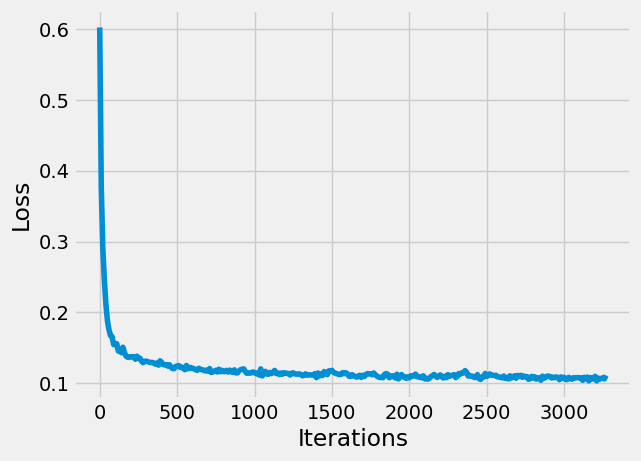

In [12]:
##########################
# Plot (smoothed) losses #
##########################

win = 10

# remove the computational graph from each tensor
losses_values = [x.detach().numpy() for x in losses] 

# rolling window average
losses_values = np.convolve(losses_values, 
                            np.ones(win), 'valid') / win

iters = np.array(range(len(losses_values)))
losses_values = losses_values[::win]
iters = iters[::win] 

plt.figure()
plt.plot(iters, losses_values) 
plt.xlabel('Iterations')
plt.ylabel('Loss');


### Reconstructed images before and after training 

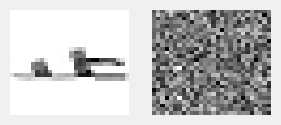

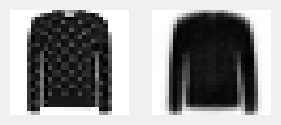

In [13]:
################################################
# Show a reconstruction of the untrained AE... #
################################################

def plot_rnd_img_and_reconstruction(outputs, outputs_idx):
    '''
    Plot a random image and its reconstruction from 
    outputs[outputs_idx]. 
    Input: an index in outputs. 
           The first item in outputs corresponds to the first batch 
           before training.  
           Every subsequent item corresponds to the last batch after 
           the corresponding training epoch. 
    '''
    max_idx = outputs[outputs_idx][1].shape[0]
    rnd_img_num = np.random.randint(0, max_idx) # last batch is 
                               # likely smaller than batch_size

    plt.figure(figsize=(3,1.3))
    plt.subplot(1, 2, 1)
    
    # outputs_idx output, 2nd item in the tuple, rnd image
    image = outputs[outputs_idx][1][rnd_img_num].detach().numpy() 
    plt.imshow(image.reshape(28,28), aspect = 'auto', 
               cmap = cm.binary)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    
    # outputs_idx output, 3rd item in the tuple, rnd image
    reconstructed = outputs[outputs_idx][2][rnd_img_num]\
                                       .detach().numpy() 
    plt.imshow(reconstructed.reshape(28,28), 
               aspect = 'auto', cmap = cm.binary)
    plt.axis('off')
    plt.show()

plot_rnd_img_and_reconstruction(outputs, 0) 

#############################################
# ...and a reconstruction of the trained AE #
#############################################

plot_rnd_img_and_reconstruction(outputs, -1) 


### The encoded (latent) data (2 numbers per image!)

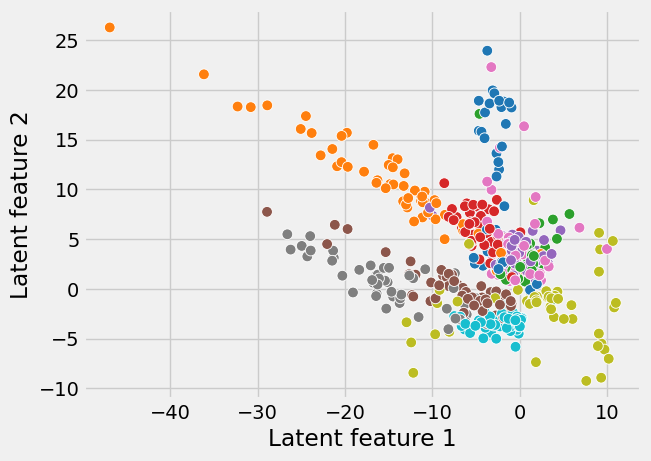

In [14]:
###########################################
# Plot the (2) values of the latent layer #
#      (for one batch of 500 images)      #
###########################################

dataloader = DataLoader(mndata, batch_size=500, shuffle=True)
# Get only the first batch in dataloader - next(iter(dataloader)). 
# Go through all the batches - for data in dataloader: ...
data = next(iter(dataloader))
image, labels = data
image = image.view(image.size(0), -1) # reshape to 
                                      # '(batch size) x (784)' 
latent,_ = model(image)

colors = []       
for lbl in labels.numpy():
    colors.append(colormaps['tab10'](lbl/10+0.01))

plt.figure()
sns.scatterplot(x=latent[:,0].detach().numpy(),
                y=latent[:,1].detach().numpy(),
                c=colors, s=60) 
plt.xlabel('Latent feature 1')
plt.ylabel('Latent feature 2');


#### The architecture matters. 

E.g., adding more latent features can 
* Reduce the losses
* Obtain better separation


Before training: Loss=0.6817
After epoch 0: Loss=0.0770
After epoch 1: Loss=0.0711
After epoch 2: Loss=0.0541
After epoch 3: Loss=0.0542
After epoch 4: Loss=0.0626
After epoch 5: Loss=0.0498
After epoch 6: Loss=0.0526


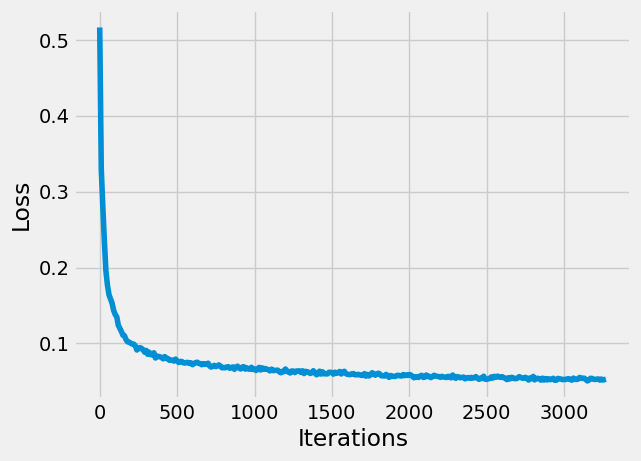

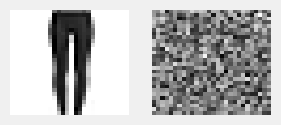

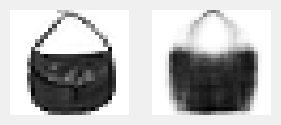

In [16]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST, FashionMNIST
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colormaps
plt.style.use('fivethirtyeight')

from sklearn.manifold import TSNE

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
# mndata = MNIST('data/MNIST', transform=img_transform, download=True)
mndata = FashionMNIST('data/Fashion-MNIST', 
                      transform=img_transform, download=True)
img_side = 28
n_mnist_pixels = img_side*img_side

num_epochs = 7
batch_size = 128 # speeds things up 
learning_rate = 2e-3
 
class AE2(torch.nn.Module):
    def __init__(self, n_latent):
        super().__init__()

        self.encoder = torch.nn.Sequential(
             torch.nn.Linear(28 * 28, 16*n_latent),
             torch.nn.ReLU(True),
             torch.nn.Linear(16*n_latent, 8*n_latent),
             torch.nn.ReLU(True), 
             torch.nn.Linear(8*n_latent, 4*n_latent), 
             torch.nn.ReLU(True), 
             torch.nn.Linear(4*n_latent, n_latent)
             )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(n_latent, 4*n_latent),
            torch.nn.ReLU(True),
            torch.nn.Linear(4*n_latent, 8*n_latent),
            torch.nn.ReLU(True),
            torch.nn.Linear(8*n_latent, 16*n_latent),
            torch.nn.ReLU(True), 
            torch.nn.Linear(16*n_latent, 28 * 28),
            torch.nn.Tanh() 
            )            

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

model2 = AE2(n_latent=16) # Try a latent 'code' with 16 neurons 
loss_function = torch.nn.MSELoss()
optimizer2 = torch.optim.AdamW(model2.parameters(),
                             lr=learning_rate,
                             )

epochs = num_epochs
outputs2 = []
losses2 = []
first = True
dataloader = DataLoader(mndata, batch_size=batch_size, shuffle=True)
for epoch in range(epochs):
    for data in dataloader:
        image, labels = data
        image = image.view(image.size(0), -1)

        latent, reconstructed = model2(image)

        loss = loss_function(reconstructed, image)

        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()

        losses2.append(loss)        
        if first:
            outputs2.append((-1, image, reconstructed))
            print('Before training: Loss=%.4f'%loss)
            first = False
        
    outputs2.append((epoch, image, reconstructed))
    print('After epoch %d: Loss=%.4f'%(epoch, loss))
    
win = 10

# remove the computational graph from each tensor
losses_values2 = [x.detach().numpy() for x in losses2] 

# rolling window average
losses_values2 = np.convolve(losses_values2, 
                             np.ones(win), 'valid') / win 
iters2 = np.array(range(len(losses_values2)))
losses_values2 = losses_values2[::win]
iters2 = iters2[::win] 

plt.figure()
plt.plot(iters2, losses_values2) 
plt.xlabel('Iterations')
plt.ylabel('Loss');

plot_rnd_img_and_reconstruction(outputs2, 0) 
plot_rnd_img_and_reconstruction(outputs2, -1); 


### Does the latent space have an interesting structure? 

* Can it be clustered? (perhaps...)
* Can t-SNE, PCA, or some other dmientionality reduction method reveal something instructive? (probably not...) 
* Is the reconstruction good enough for this dimentionality reduction to be useful for some downstream application? 

<br/> 

<br/> 

Feel free to play with it. 